In [1]:
import numpy as np
import networkx as nx

In [2]:
G = nx.Graph()

blue,orange,green = "#1f77b4","#ff7f0e","#2ca02c"
G.add_nodes_from([
    (1,{"color":blue}),
    (2,{"color":orange}),
    (3,{"color":blue}),
    (4,{"color":green})
])
G.add_edges_from([(1,2),(2,3),(1,3),(3,4)])
A = np.asarray(nx.adjacency_matrix(G).todense())
A

array([[0, 1, 1, 0],
       [1, 0, 1, 0],
       [1, 1, 0, 1],
       [0, 0, 1, 0]])

In [3]:
def build_graph_color_label_representation(G,mapping_dict):
    one_hot_idxs = np.array([mapping_dict[v] for v in 
                             nx.get_node_attributes(G,'color').values()])
    one_hot_encoding = np.zeros((one_hot_idxs.size,len(mapping_dict)))
    one_hot_encoding[
        np.arange(one_hot_idxs.size),one_hot_idxs
    ] = 1
    return one_hot_encoding
X = build_graph_color_label_representation(G,{green:0,blue:1,orange:2})
X

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.]])

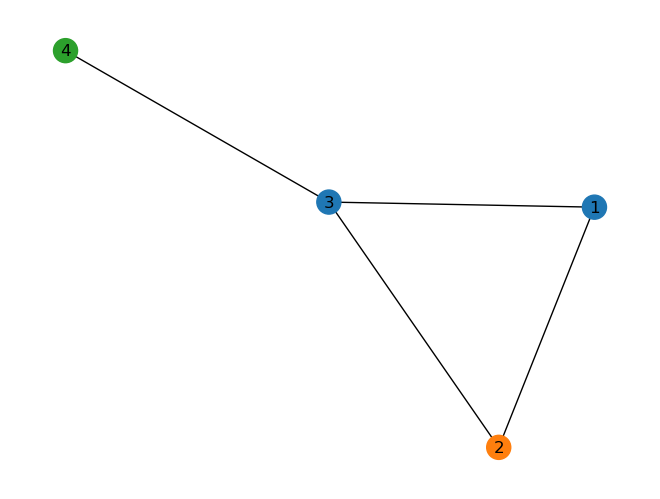

In [4]:
color_map = nx.get_node_attributes(G,'color').values()
nx.draw(G,with_labels=True,node_color=color_map)

In [5]:
f_in,f_out = X.shape[1],6
W_1 = np.random.rand(f_in,f_out)
W_2 = np.random.rand(f_in,f_out)
h = np.dot(X,W_1) + np.dot(np.dot(A,X),W_2)

#### Defining the NodeNetwork model

In [6]:
import networkx as nx
import torch
from torch.nn.parameter import Parameter
import numpy as np
import math
import torch.nn.functional as F

In [7]:
class NodeNetwork(torch.nn.Module):
    def __init__(self,input_features):
        super().__init__()
        self.conv_1 = BasicGraphConvolutionLayer(input_features,32)
        self.conv_2 = BasicGraphConvolutionLayer(32,32)
        self.fc_1 = torch.nn.Linear(32,16)
        self.out_layer = torch.nn.Linear(16,2)
        
        
    def forward(self,X,A,batch_mat):
        x = F.relu(self.conv_1(X,A))
        x = F.relu(self.conv_2(x,A))
        output = global_sum_pool(x,batch_mat)
        output = self.fc_1(output)
        output = self.out_layer(output)
        return F.softmax(output,dim=1)

#### NodeNetwork's graph convolution layer

In [8]:
class BasicGraphConvolutionLayer(torch.nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.W2 = Parameter(torch.rand((in_channels,out_channels),dtype=torch.float32))
        self.W1 = Parameter(torch.rand((in_channels,out_channels),dtype=torch.float32))
        self.bias = Parameter(torch.zeros(out_channels,dtype=torch.float32))
        
    def forward(self,X,A):
        potential_msgs = torch.mm(X,self.W2)
        propagated_msgs = torch.mm(A,potential_msgs)
        root_update = torch.mm(X,self.W1)
        output = propagated_msgs + root_update + self.bias
        return output

In [9]:
X.shape

(4, 3)

In [14]:
A.shape

(4, 4)

In [11]:
basiclayer = BasicGraphConvolutionLayer(3,8)
out = basiclayer(X = torch.tensor(X,dtype=torch.float32),
                A = torch.tensor(A,dtype=torch.float32)
                )
out.shape

torch.Size([4, 8])

In [12]:
def global_sum_pool(X,batch_mat):
    if batch_mat is None or batch_mat.dim() == 1:
        return torch.sum(X,dim=0).unsqueeze(0)
    else:
        return torch.mm(batch_mat,X)

In [13]:
from torch_geometric.datasets import QM9
from torch_geometric.loader import DataLoader

In [31]:
from torch_geometric.nn import NNConv,global_add_pool
import torch.nn as nn

In [16]:
# loading the QM9 dataset
dset = QM9('.')
dset

Extracting ./raw/qm9_v3.zip
Processing...
Using a pre-processed version of the dataset. Please install 'rdkit' to alternatively process the raw data.
Done!


QM9(130831)

In [17]:
len(dset)

130831

In [18]:
data = dset[0]
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5])

In [19]:
data.z

tensor([6, 1, 1, 1, 1])

In [20]:
data.new_attribute = torch.tensor([1,2,3])
data

Data(x=[5, 11], edge_index=[2, 8], edge_attr=[8, 4], y=[1, 19], pos=[5, 3], idx=[1], name='gdb_1', z=[5], new_attribute=[3])

In [21]:
data.new_attribute

tensor([1, 2, 3])

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
data.to(device)
data.new_attribute.is_cuda

False

In [24]:
data.x

tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [32]:
class ExampleNet(torch.nn.Module):
    def __init__(self,num_node_features,num_edge_features):
        super().__init__()
        conv1_net = nn.Sequential(nn.Linear(num_edge_features,32),
                                 nn.ReLU(),
                                 nn.Linear(32,num_node_features*32))
        
        conv2_net = nn.Sequential(nn.Linear(num_edge_features,32),
                                 nn.ReLU(),
                                 nn.Linear(32,32*16))
        self.conv1 = NNConv(num_node_features,32,conv1_net)
        self.conv2 = NNConv(32,16,conv2_net)
        self.fc_1 = nn.Linear(16,32)
        self.out = nn.Linear(32,1)
        
    def forward(self,data):
        batch,x,edge_index,edge_attr = (data.batch,data.x,data.edge_index,data.edge_attr)
        
        x = F.relu(self.conv1(x,edge_index,edge_attr))
        
        x = F.relu(self.conv2(x,edge_index,edge_attr))
        
        x = global_add_pool(x,batch)
        x = F.relu(self.fc_1(x))
        output = self.out(x)
        return output

In [33]:
from torch.utils.data import random_split

train_set,valid_set,test_set = random_split(dset,[110000,10831,10000])
trainloader = DataLoader(train_set,batch_size=32,shuffle=True)
validloader = DataLoader(valid_set,batch_size=32,shuffle=True)
testloader = DataLoader(test_set,batch_size=32,shuffle=True)

In [37]:
qm9_node_feats,qm9_edge_feats = 11,4
net = ExampleNet(qm9_node_feats,qm9_edge_feats)

optimizer = torch.optim.Adam(net.parameters(),lr=0.01)
epochs = 4
target_idx = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

ExampleNet(
  (conv1): NNConv(11, 32, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=352, bias=True)
  ))
  (conv2): NNConv(32, 16, aggr=add, nn=Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=512, bias=True)
  ))
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [38]:
for total_epochs in range(epochs):
    epoch_loss = 0
    total_graphs = 0
    net.train()
    for batch in trainloader:
        batch.to(device)
        optimizer.zero_grad()
        output = net(batch)
        loss = F.mse_loss(output,batch.y[:,target_idx].unsqueeze(1))
        loss.backward()
        epoch_loss += loss.item()
        total_graphs += batch.num_graphs
        optimizer.step()
    train_avg_loss = epoch_loss / total_graphs
    val_loss = 0
    total_graphs = 0
    net.eval()
    for batch in validloader:
        batch.to(device)
        output = net(batch)
        loss = F.mse_loss(output,batch.y[:,target_idx].unsqueeze(1))
        val_loss += loss.item()
        total_graphs += batch.num_graphs
    val_avg_loss = val_loss / total_graphs
    print(f'Epochs: {total_epochs} | epoch avg. loss: {train_avg_loss:.4f} | validation avg. loss: {val_avg_loss:.4f}')

Epochs: 0 | epoch avg. loss: 0.5341 | validation avg. loss: 0.1378
Epochs: 1 | epoch avg. loss: 0.1463 | validation avg. loss: 0.0975
Epochs: 2 | epoch avg. loss: 0.1107 | validation avg. loss: 0.0692
Epochs: 3 | epoch avg. loss: 0.0977 | validation avg. loss: 0.0750


In [39]:
net.eval()
predictions = []
real = []
for batch in testloader:
    output = net(batch.to(device))
    predictions.append(output.detach().cpu().numpy())
    real.append(batch.y[:,target_idx].detach().cpu().numpy())
real = np.concatenate(real)
predictions = np.concatenate(predictions)

Text(0, 0.5, 'Predicted isotropic polarizability')

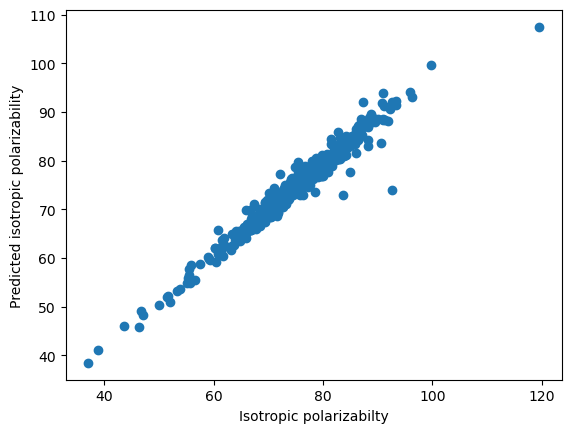

In [40]:
import matplotlib.pyplot as plt
plt.scatter(real[:500],predictions[:500])
plt.xlabel("Isotropic polarizabilty")
plt.ylabel("Predicted isotropic polarizability")